In [34]:
import antropy
import numpy as np
import matplotlib.pyplot as plt
#mamba install antropy

In [35]:
def norris_pulse(t,t0,A,tr,r,pk):
    tn = np.array([(t0-ti) if(ti<t0) else (ti-t0) for ti in t])
    tex = np.array([tr if(ti<t0) else r*tr for ti in t])
    c = A*np.exp(-(tn/tex)**pk)
    return c

/home/romain/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


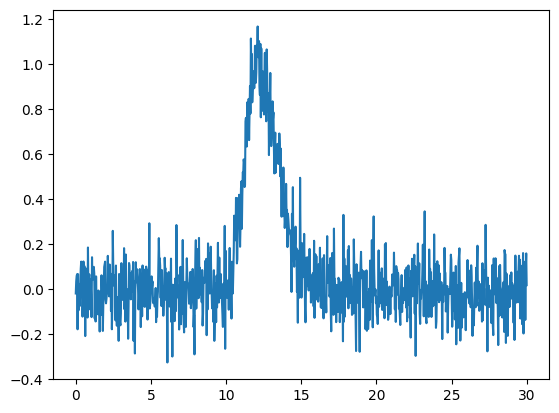

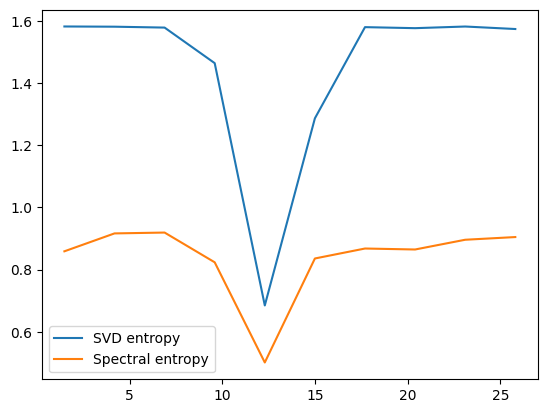

In [54]:
# create a function that takes a time series in input (array) and apply a rolling window to it with partially overlapped windows
# the function returns a list of time windows and array of the time series with the same length of the windows
def rolling_window(time,time_series, window_size, overlap):
    windows = []
    time_series_rolled = []
    for i in range(0, len(time_series)-window_size, window_size-overlap):
        windows.append(np.median(time[i:i+window_size]))
        time_series_rolled.append(time_series[i:i+window_size])
    return windows, time_series_rolled

# create a function that apply some function to each window of a time series
def entropy_window(time,time_series, entropy_function,params,window_size,overlap):
    windows, time_series_rolled = rolling_window(time,time_series, window_size, overlap)
    entropy_values = []
    for i in range(len(windows)):
        entropy_values.append(entropy_function(time_series_rolled[i],params))
    return entropy_values

In [67]:
def shannon_entropy(probas):
    return -np.sum(probas*np.log2(1e-10+probas))

def Renyi_entropy(probas,alpha):
    return np.log2(np.sum(probas**alpha))/(1-alpha)
    
def svd_entropy(time_series,params):
    order=params[0]
    delay=params[1]
    return antropy.svd_entropy(time_series, order=order, delay=delay)

def spectral_entropy(time_series,params):
    return antropy.spectral_entropy(time_series, sf=100, method='welch', normalize=True)

def _embed(x, order=3, delay=1):
    """Time-delay embedding.

    Parameters
    ----------
    x : array_like
        1D-array of shape (n_times) or 2D-array of shape (signal_indice, n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.

    Returns
    -------
    embedded : array_like
        Embedded time series, of shape (..., n_times - (order - 1) * delay, order)
    """
    x = np.asarray(x)
    N = x.shape[-1]
    assert x.ndim in [1, 2], "Only 1D or 2D arrays are currently supported."
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")

    if x.ndim == 1:
        # 1D array (n_times)
        Y = np.zeros((order, N - (order - 1) * delay))
        for i in range(order):
            Y[i] = x[(i * delay) : (i * delay + Y.shape[1])]
        return Y.T
    else:
        # 2D array (signal_indice, n_times)
        Y = []
        # pre-defiend an empty list to store numpy.array (concatenate with a list is faster)
        embed_signal_length = N - (order - 1) * delay
        # define the new signal length
        indice = [[(i * delay), (i * delay + embed_signal_length)] for i in range(order)]
        # generate a list of slice indice on input signal
        for i in range(order):
            # loop with the order
            temp = x[:, indice[i][0] : indice[i][1]].reshape(-1, embed_signal_length, 1)
            # slicing the signal with the indice of each order (vectorized operation)
            Y.append(temp)
            # append the sliced signal to list
        Y = np.concatenate(Y, axis=-1)
        return Y

def svd_entropy_Renyi(x,params,normalize=False):
    order=int(params[0])
    delay=int(params[1])
    alpha=params[2]
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = Renyi_entropy(W,alpha)
    if normalize:
        svd_e /= np.log2(order)
    return svd_e

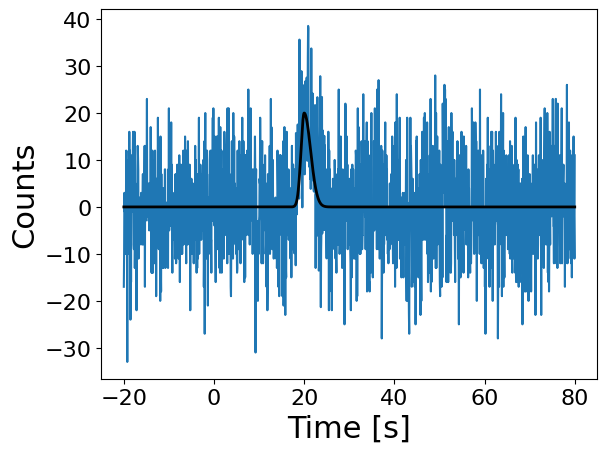

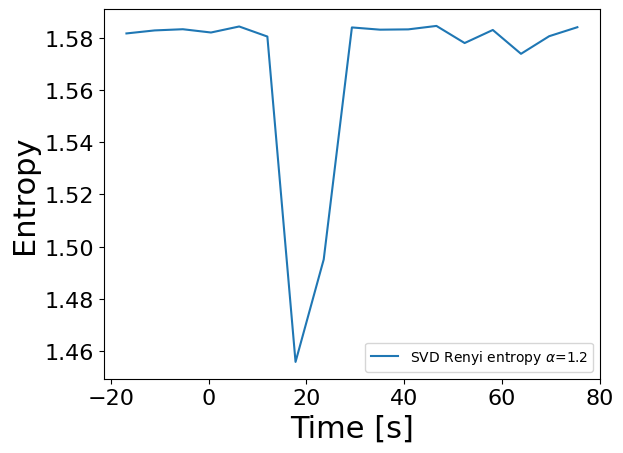

In [140]:
# create a time series
ti,tf=-20,80
bin_time=0.064
time = np.linspace(ti,tf, int((tf-ti)/bin_time))
# plot the signal from different windows
window_size = 100
overlap = 10

t0=20
A=20
tr=1
r=2
pk=2
level_noise=100
time_series =np.random.poisson(level_noise,size=len(time))-level_noise+norris_pulse(time,t0,A,tr,r,pk)
#time_series =np.random.normal(0,level_noise,size=len(time))+norris_pulse(time,t0,A,tr,r,pk)

windows, time_series_rolled = rolling_window(time,time_series, window_size, overlap)

#plt.figure(figsize=(12,8))

plt.plot(time, time_series, label='Original signal')
plt.plot(time, norris_pulse(time,t0,A,tr,r,pk), color='k',lw=2.)
plt.xlabel('Time [s]',size=22)
plt.ylabel('Counts',size=22)
plt.xticks(size=16)
plt.yticks(size=16)
#for i in range(len(windows)):
#    plt.plot(windows[i],time_series_rolled[i], label='Window '+str(i))
# apply a function to each window
params=np.array([3,1])

svd_entropy_values = entropy_window(time,time_series, svd_entropy, params,window_size,overlap)


plt.figure()

plt.xlabel('Time [s]',size=22)
plt.ylabel('Entropy',size=22)
plt.xticks(size=16)
plt.yticks(size=16)

#for alpha in [1,2,6,10,20,80]:
alpha=1.2
params=np.array([3,1,alpha])
svd_entropy_Renyi_values = entropy_window(time,time_series, svd_entropy_Renyi, params,window_size,overlap)
    #plt.plot(windows,svd_entropy_Renyi_values,label='SVD entropy')
plt.plot(windows,svd_entropy_Renyi_values+(np.max(svd_entropy_values)-np.max(svd_entropy_Renyi_values)),label='SVD Renyi entropy '+ r'$\alpha$={0}'.format(params[2]))
#spectral_entropy_values = entropy_window(time,time_series, spectral_entropy, params,window_size,overlap)
#plt.figure()
#plt.plot(windows,svd_entropy_Renyi_values+(np.max(svd_entropy_values)-np.max(svd_entropy_Renyi_values)),label='SVD entropy Renyi '+ r'$\alpha$={0}'.format(params[2]))
#plt.plot(windows,spectral_entropy_values,label='Spectral entropy')
plt.legend()

Signature: antropy.svd_entropy(x, order=3, delay=1, normalize=False)
Source:   
def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of SVD entropy (= length of the embedding dimension).
        Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    svd_e : float
        SVD Entropy

    Notes
    -----
    SVD entropy is an indicator of the number of eigenvectors that are needed
    for an adequate explanation of the data set. In other words, it measures
    the dimensionality of the data.

    The SVD entropy of a signal :math:`x` is defined as:

    .. math::
        H = -\\sum_{i=1}^{M} \\overlin